In [48]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 124
setup_one_gpu(GPU)

ValueError: GPU setup must happen before importing TensorFlow

In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id
from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_wgan import RawWGAN

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances, jensen_shannon_divergence

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
n_pc_samples = 2048
do_training = True
do_plotting = True
save_model = False
save_synthetic_samples = True
seed = 42
voxel_resolution = 32

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'
experiment_name = 'raw_gan_' + class_name +'_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [8]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
train_data = PointCloudDataSet(full_pclouds)

gt_m_entropy, gt_voxel_rv = entropy_of_occupancy_grid(full_pclouds, voxel_resolution)
print gt_m_entropy

6778 files containing complete point clouds were found.
0.0742874735364


In [11]:
init_lr = 0.0005
max_epochs = 100
batch_size = 50
noise_params = {'mu':0, 'sigma': 1}

n_syn_samples = train_data.num_examples  # Same number as original GT data.
accum_syn_data = []
train_stats = []

reset_tf_graph()
gan = RawGAN(experiment_name, learning_rate=init_lr, n_output=[n_pc_samples, 3])

In [12]:
if do_training:
    for _ in range(max_epochs):
        checkpoint_path = osp.join(train_dir, model_saver_id)
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model:
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)
        accum_syn_data.append(gan.generate(n_syn_samples, noise_params))

1 (1.1350741779362714, 1.1342749847306146) 28.2805230618
2 (1.2629836559295655, 0.93759376340442235) 28.1493110657
3 (1.2098356661973175, 1.0892106806790387) 28.2263860703
4 (1.0961403590661507, 1.5011498049453453) 28.2362220287
5 (0.98836060100131562, 1.663146490962417) 28.2837929726
6 (0.9538506927313628, 1.9181670164620435) 28.3334410191
7 (0.90499035870587385, 1.9714757064978281) 28.2774000168
8 (1.0928291413519118, 1.6062803431793495) 28.3207671642
9 (1.0931385702557035, 1.4325215306546952) 28.4669110775
10 (1.0784244228292394, 1.4093994225616808) 28.3410251141
11 (1.1248992994979576, 1.4136088463995191) 28.3653321266
12 (1.1298679894871182, 1.2642383160414519) 28.3072099686
13 (1.127528351324576, 1.3498783842281059) 28.3742449284
14 (1.1160419826154355, 1.2416023445350153) 28.4033761024
15 (1.0803246122819405, 1.32504455656917) 28.400069952
16 (1.0581133242006655, 1.3625915851857928) 28.4043409824
17 (1.0580718914667766, 1.404336189671799) 28.544426918
18 (1.0035233590337964, 1.4

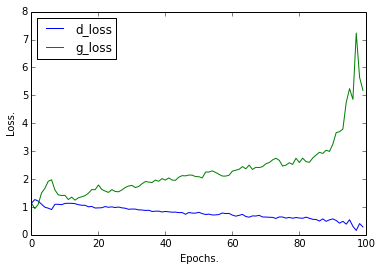

In [13]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [14]:
jsd = []
emd_dists = []

# from general_tools.simpletons import iterate_in_chunks

for sdata in accum_syn_data:    
    sdata_r = sdata[:1000] # reduced    
    for i, pc in enumerate(sdata_r): # in u sphere
        sdata_r[i] = Point_Cloud(pc).center_in_unit_sphere().points
        
    _, s_var = entropy_of_occupancy_grid(sdata_r, voxel_resolution)
    jsd.append(jensen_shannon_divergence(gt_voxel_rv,  s_var))
    emd_dists.append(point_cloud_distances(sdata_r, 10, gan.sess, 'emd'))
mean_emd_dists = [np.mean(i) for i in emd_dists]

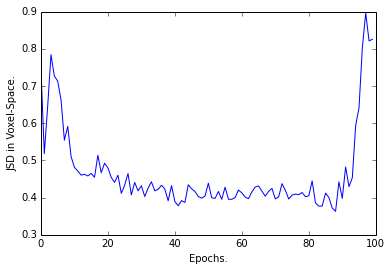

In [16]:
plt.plot(range(len(jsd)), jsd)
plt.xlabel('Epochs.')
plt.ylabel('JSD in Voxel-Space.')

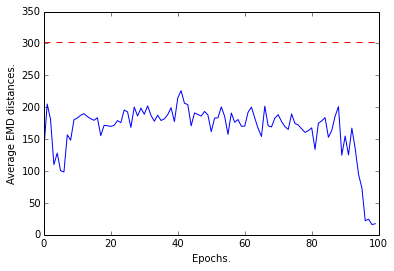

In [17]:
plt.xlabel('Epochs.')
plt.ylabel('Average EMD distances.')
plt.plot(range(len(mean_emd_dists)), mean_emd_dists)
plt.plot(range(len(mean_emd_dists)), np.ones(len(mean_emd_dists)) * 302.4, '--r' )

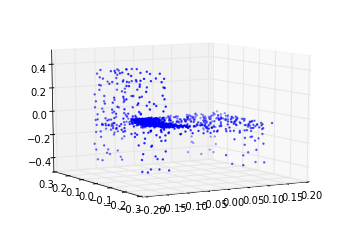

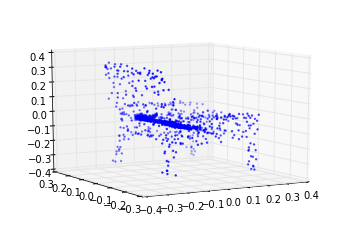

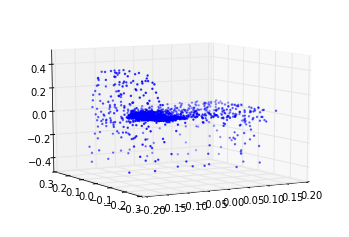

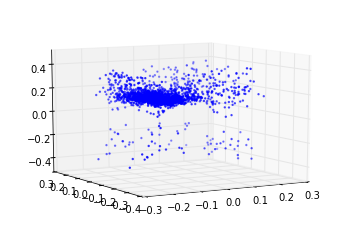

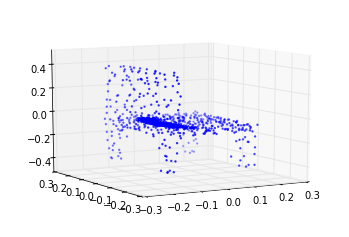

In [42]:
epoch_to_check = 40
check_data = accum_syn_data[epoch_to_check]
rids = np.random.choice(range(len(check_data)), size=5, replace=False)

for i in range(5):
    Point_Cloud(check_data[rids[i]]).plot()
    
save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch_to_check))
np.savez(save_out, check_data)


In [41]:
save_out

'/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/raw_gan_chair_2048_pts_epoch_40'

In [ ]:
# First put in u-sphere then save.
if save_synthetic_samples:
    for i, pc in enumerate(syn_data):        
        pc = Point_Cloud(syn_data_rot[i]).center_in_unit_sphere()
        syn_data_rot[i] = pc.points
        
    save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch))
    np.savez(save_out, syn_data_rot)

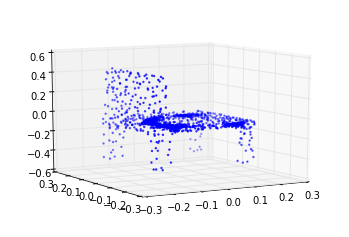

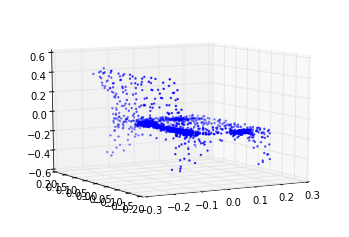

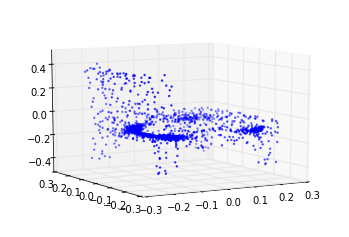

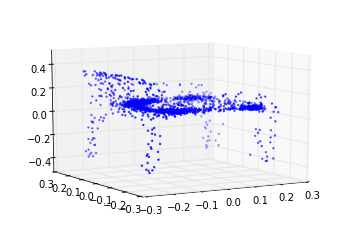

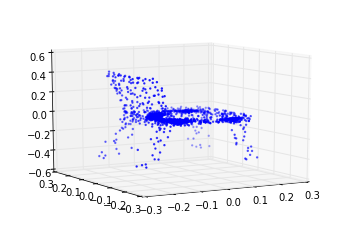

In [39]:
for i in range(5):
    Point_Cloud(gan.generate(1, noise_params)[0]).plot()